# Imports and Settings

In [1]:
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import boxcox, chi2_contingency, f, f_oneway, probplot
import seaborn as sns

In [2]:
sns.set_palette("deep")
sns.set_style("white")

# Loading

In [3]:
# Loaded here because being default argument in some functions
cleaned_df = pd.read_csv("csvs/cleaned_dataset.csv")
cleaned_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Functions

In [4]:
def bar_chart(df:pd.DataFrame, var: str, out: bool = False) -> None:
    """
    Draw bar chart for nominal variables
    `out` set to True allows to export the graph in png format in the graphs folder.
    """
    total = len(df)
    ax = sns.countplot(x=var, data=df,
                       hue=var)
    
    for p in ax.patches:
        height = p.get_height()
        percentage = '{:.0f}%'.format(100 * height/total)
        ax.text(p.get_x() + p.get_width() / 2., height + 3, percentage, ha="center")
        ax.set_title(f"{var}'s bar chart",
                     size="x-large", weight="bold", color="blue")

    if out:
        plt.savefig(f"graphs/{var}_bar_chart.png", dpi=300)
    
    plt.show()

In [5]:
def catplot(x: str, y: str = "charges", df: pd.DataFrame = cleaned_df,
            out: bool = True) -> None:
    """
    Draw a boxplot crossing informations between:
    - the continuous variable y
    - the nominal variable x
    `out` set to True allows to export the output in .csv format in csvs folder.
    """
    sns.catplot(x=x,
                y=y,
                hue=x,
                data=df,
                legend=False,
                kind="box")

    plt.title(f"Boxplot of {y} vs {x}",
              size="x-large", weight="bold", c="b")
    plt.xticks(rotation=90)

    if out:
        plt.savefig(f"graphs/boxplot_{y}_vs_{x}.png", dpi=300)
    
    plt.show()

In [6]:
def contingency_table(
    var1: str, var2: str, df: pd.DataFrame = cleaned_df,
    out: bool = True) -> pd.DataFrame:
    """
    Get the contingency table for two nominal features of a DataFrame.
    `out` set to True allows to export the output in .csv format in csvs folder.
    """
    ct = pd.crosstab(df[var1], df[var2])
    if out:
        ct.to_csv(f"csvs/{var1}_{var2}_ct.csv", index=True)
    return ct

In [7]:
def correlation_heatmap(df: pd.DataFrame = cleaned_df, out: bool = True) -> None:
    """
    Displays correlations between numerical features of a DataFrame.
    `out` set to True allows to export the graph in png format in the graphs folder.
    """
    corr = df.select_dtypes(include="number").corr()
    # Create a matrix full of zeros similar to corr
    mask = np.zeros_like(corr)
    # Set the upper triangle of the mask to True
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
      fig, ax = plt.subplots(figsize=(6, 6))
      ax = sns.heatmap(
        corr,
        # MASK
        mask=mask,
        # Div palette, suffix _r to reverse
        cmap="RdBu_r", # coolwarm, vlag, icefire
        # Text in heatmap
        annot=True,# Allowing annotations.
        fmt=".2f", # Formatting annotations. 
        annot_kws=dict(
          fontsize=9,
          fontweight="bold"
          ), # Other formatting
        # Values on vertical colorbar
        vmax=1,
        center=0,
        vmin=-1,
        )
    plt.title("Correlations Heatmap", size="x-large", weight="bold", c="b")

    if out:
        plt.savefig("graphs/correlations_heatmap.png", dpi=300)
        
    plt.show()

In [8]:
def cramers_v(ct: pd.DataFrame, chi2: float) -> float:
    """
    Perform Cramer's V test to measure correlation between two nominal variables,
    Params
    ------
        ct: the observed contingency table,
        chi2: the chi2 result of scipy.stats.contingency function on ct.
    """
    n = ct.sum().sum()  # Retrieve the number of observations
    n_rows, n_cols = ct.shape
    phi2 = chi2 / n
    phi2corr = max(0, phi2 - (n_rows - 1) * (n_cols - 1) / (n - 1))
    row_corr = n_rows - ((n_rows - 1) ** 2) / (n - 1)
    col_corr = n_cols - ((n_cols - 1) ** 2) / (n - 1)
    cramer_v = np.sqrt(phi2corr / min(row_corr - 1, col_corr - 1))
    return cramer_v

In [9]:
def draw_probplot(var: str, df: pd.DataFrame = cleaned_df, out: bool = False) -> None:
    """
    Draw a qqplot of the variable to check its normality.
    `out` set to True allows to export the graph in .png format in the graphs folder.
    """
    probplot(df[var], dist="norm", plot=plt)
    plt.title(f"QQ Plot for {var}",
              size="x-large", weight="bold", color="blue")
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')

    if out:
       plt.savefig(f"graphs/{var}_qqplot.png", dpi=300)

    plt.show()

In [10]:
def extract_var_outliers(df: pd.DataFrame, var: str, out: bool = False) -> pd.DataFrame:
    """
    Spots outliers (according to how they're defined on a boxplot)
    from the feature `feat` of the DataFrame `df`
    `out` set to True allows to export the output in .csv format in csvs folder.
    """
    q1, q3 = df[var].quantile([.25, .75])
    iqr = q3 - q1
    outliers = df[df[var] > q3 + 1.5 * iqr]
    if out:
        outliers.to_csv(f"csvs/{var}_outliers.csv", index=False)
    return outliers

In [11]:
def hist_box_plot(df: pd.DataFrame, col: str, out: bool = False) -> None:
    """
    Display an histogram and a boxplot of df[col],
    col being a continuous numerical variable.
    `out` set to True allows to export the graph in .png format.
    """
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
    mean=df[col].mean()
    median=df[col].median()
    mode=df[col].mode().values[0]
     
    sns.boxplot(data=df, x=col, ax=ax_box)
    ax_box.axvline(mean, color='r', linestyle='--')
    ax_box.axvline(median, color='g', linestyle='-')
    ax_box.axvline(mode, color='b', linestyle='-')
     
    sns.histplot(data=df, x=col, ax=ax_hist, kde=True)
    ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
    ax_hist.axvline(median, color='g', linestyle='-', label="Median")
    ax_hist.axvline(mode, color='b', linestyle='-', label="Mode")
     
    ax_hist.legend(loc='best')
     
    ax_box.set(xlabel='')

    plt.suptitle(f"Distribution of {col} variable",
                 size="x-large", weight="bold", color="blue")

    if out:
        plt.savefig(f"graphs/{col}_hist_box.png", dpi=300)
        
    plt.show()

In [54]:
def kdeplots(cat: str, x: str = "charges", df: pd.DataFrame = cleaned_df,
             out: bool = True) -> None:
    """
    Draw kdeplots of charges according to modalities of `cat`
    `out` set to True allows to export the graph in png format in the graphs folder.
    """
    sns.kdeplot(x=x, hue=cat, data=df)

    plt.title(f"Kdeplots of {x} by {cat}",
              size="x-large", weight="bold", c="b")
    
    if out:
        plt.savefig(f"graphs/kdeplots_{x}_by_{cat}.png", dpi=300)
    
    plt.show()

In [12]:
def lineplot(x: str, y: str = "charges", df: pd.DataFrame = cleaned_df,
             cat: Optional[str] = None,
             estimator: str = "mean",
             out:bool = False) -> None:
    """
    Draw a lineplot between two numerical variables x and y.
    `cat` set to a nominal variable's name allows to color the graph and draw multiples.
    `estimator` allows to specify the estimator used for bootstrapping.
    `out` set to True allows to export the graph in .png format in the graphs folder.
    """
    sns.relplot(x=x, y=y, data=df,
                kind="line",
                estimator=estimator,
                hue=cat,
                col=cat, col_wrap=df[cat].nunique() // 2 if cat else None)
    graph_title = f"Line plot of {estimator} {y} by {x}"
    file_name = f"line_plot_{estimator}_{y}_by_{x}"
    
    if cat:
        graph_title += f" and {cat}"
        file_name += f"_and_{cat}"
        
    plt.suptitle(graph_title, size="x-large", weight="bold", color="blue",
                 y=1.05)
    plt.ylabel(f"{estimator} {y}")
    if out:
        plt.savefig(f"graphs/{file_name}.png", dpi=300)

    plt.show()

In [13]:
def one_way_anova(
    nom_var: str, num_var: str = "charges",
    df: pd.DataFrame = cleaned_df
) -> Tuple[float, float]:
    """
    Perform one way ANOVA between a nominal variable and a numerical one,
    using `f_oneway` function from `scipy.stats`
    `num_var` is set by default to the target: `charges` of
    `cleaned_df`, which is the default `df`.
    """
    grouped_data = [group[num_var].values
                    for name, group in df.groupby(nom_var)]
    f_statistic, p_value = f_oneway(*grouped_data)
    return f_statistic, p_value

In [14]:
def pairplot(df: pd.DataFrame = cleaned_df,
             cat: Optional[str] = None,
             out: bool = False) -> None:
    """
    Draw a pairplot of the `df` DataFrame
    `hue` allows to color scatterplots according to a nominal variable
    `out` set to True allows to export the graph in .png format in the graphs folder.
    """
    sns.pairplot(data=df, hue=cat, corner=True)
    title = "Pair Plot"
    if cat:
        title += f" Colored by {cat}"

    plt.suptitle(title,
                 size="x-large", weight="bold", color="blue",
                 y=1)

    if out:
        file_name = "pairplot"
        if cat:
            file_name += f"_hue_{cat}"
        plt.savefig(f"graphs/{file_name}.png", dpi=300)

    plt.show() 

In [15]:
def split_bmi_in_four(x: float) -> str:
    if x < 18.5:
        return "Underweight"
    if x < 25:
        return "Normal Weight"
    if x < 30:
        return "Overweight"
    return "Obesity"

In [16]:
def split_bmi_in_six(x: float) -> str:
    if x < 18.5:
        return "Underweight"
    if x < 25:
        return "Normal Weight"
    if x < 30:
        return "Overweight"
    if x < 35:
        return "Class I Obesity"
    if x < 40:
        return "Class II Obesity"
    return "Class III Obesity"

# Overview

## Numerical

In [17]:
cleaned_df.sample(5)

,age,sex,bmi,children,smoker,region,charges
1279,48,female,33.330,0,no,southeast,8283.68070
1188,23,female,28.000,0,no,southwest,13126.67745
1295,18,male,26.125,0,no,northeast,1708.92575
1236,58,female,28.215,0,no,northwest,12224.35085
414,19,female,35.150,0,no,northwest,2134.90150


In [18]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [19]:
cleaned_df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


## Graphical (Pairplots)

### Global

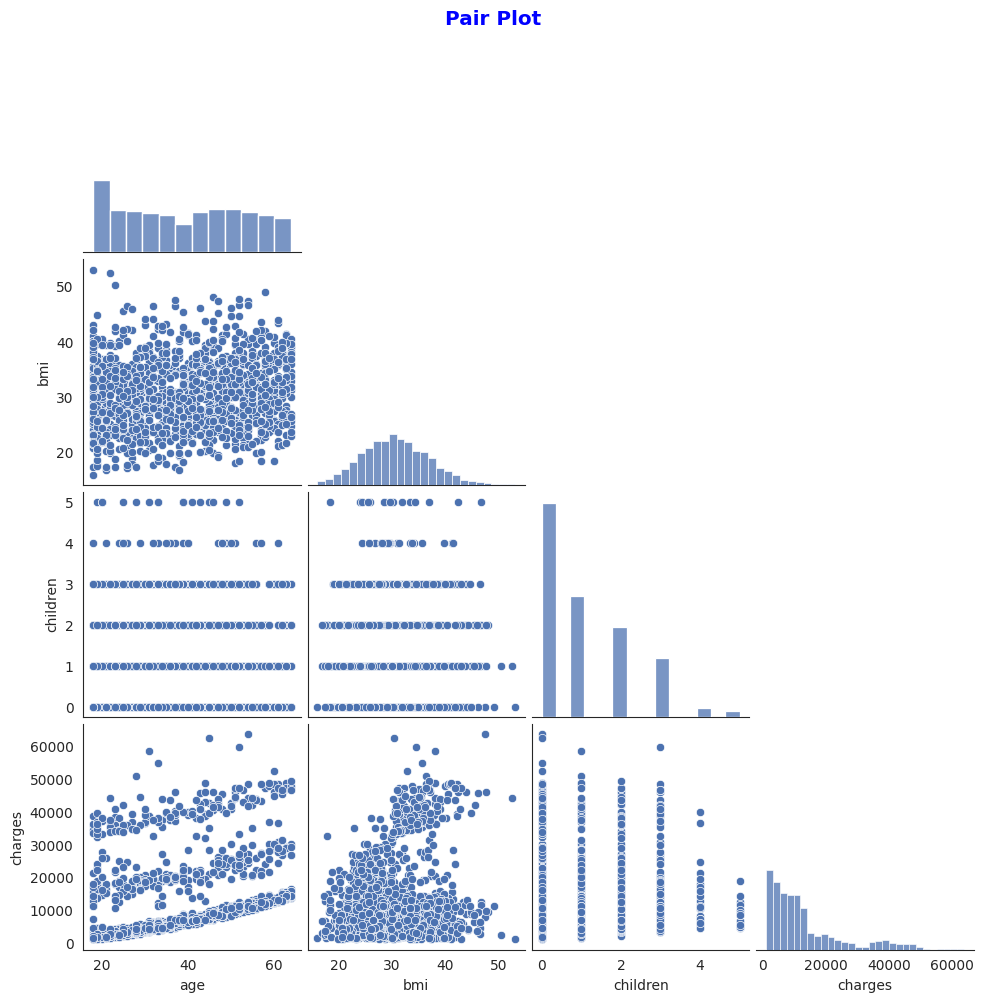

In [20]:
pairplot(out=True)

### Colored by `smoker`

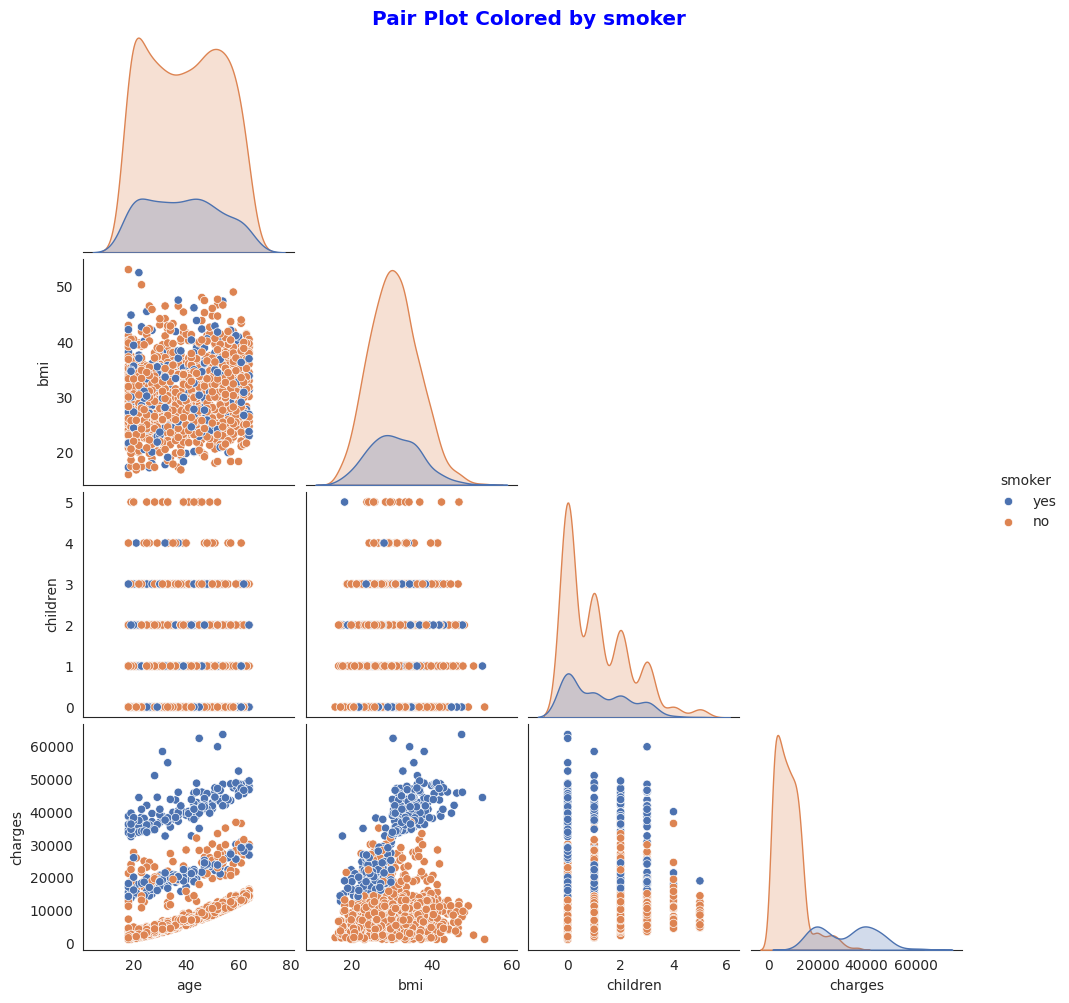

In [21]:
pairplot(cat="smoker", out=True)

> **ANALYSIS**
>
> The kdeplot on bottom right illustrates without any doubt how non smoker pay less than smokers.
>
> The scatterplot crossing bmi and charges lets think that there's a clear relation between being a `smoker` AND increasing `bmi` with increasing `charges`.

### Colored by `region`

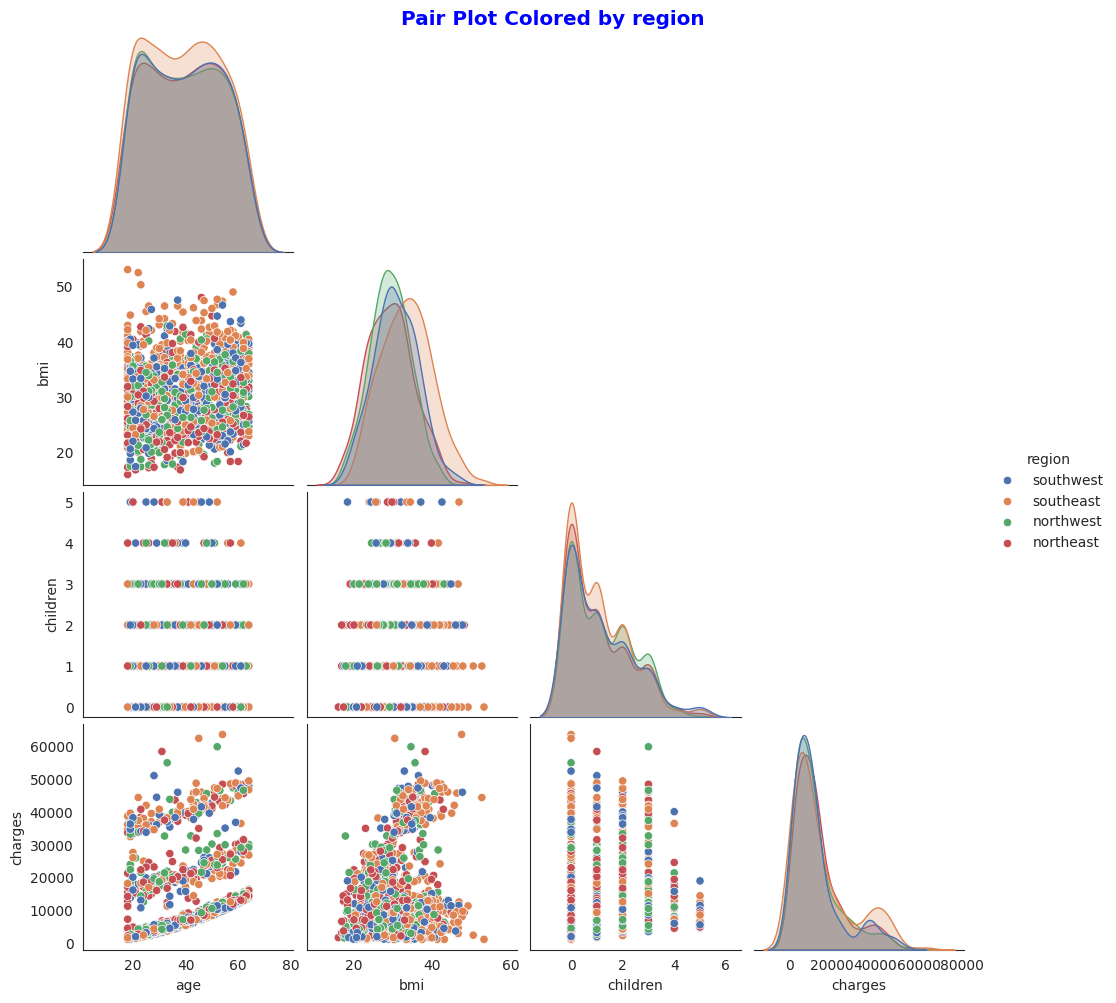

In [22]:
pairplot(cat="region", out=True)

> **ANALYSIS**
>
> The kdeplot on bottom right shows that there seems to be a sligh difference in `charges` for people from the SouthWest region.

# Univariate Analysis

## Numerical Features + Target

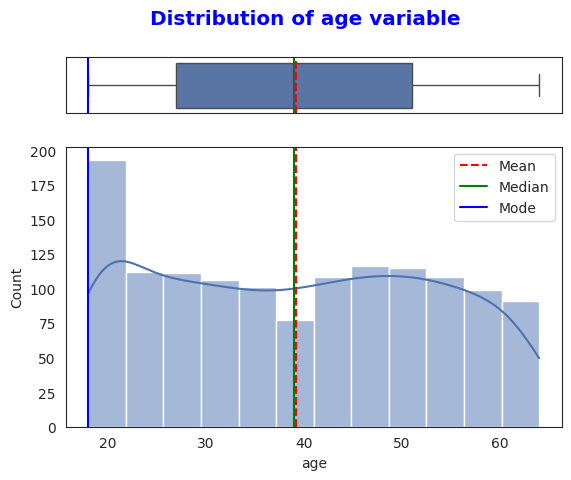

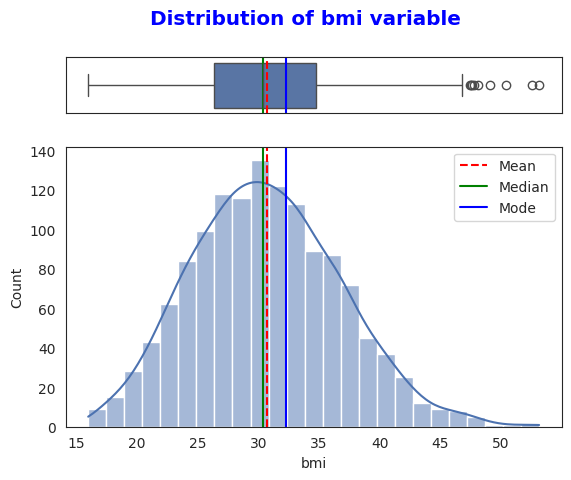

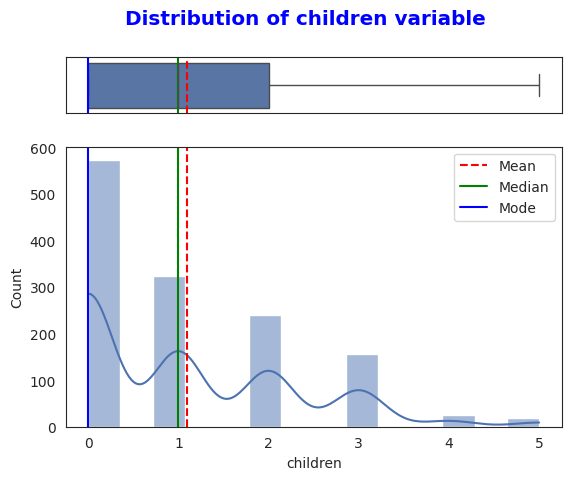

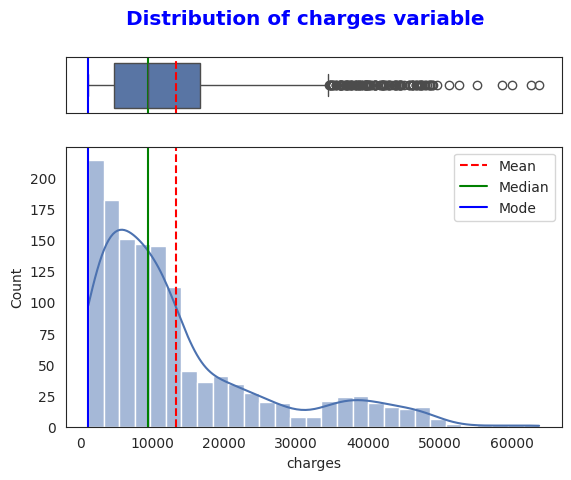

In [23]:
for col in cleaned_df.select_dtypes(exclude="object").columns:
    hist_box_plot(cleaned_df, col, out=True)

> **ANALYSIS**
>
> `age` is a rather uniform distribution, as mean and median are centered, except for a mode located on young people, being majoritary around 18 and 19.
>
> `bmi` seems to follow a "normal-like" distribution, as the three central tendancies are centered.
> Nevertheless, **the boxplot shows some outliers we could take profit to study**, in regard to how high their charges should be. (and in correlation, maybe, to other health-issuing factors)
>
> Naturally, `children` is skewed to the right, the mode being to 0.
>
> `charges` is skewed to the right, with a "mode" being its lowest value. **When performing machine learning, this will lead us to transform this distribution to ensure the most of "normality", in order to satisfy linear regression's assumptions**.
>
> Interestingly, there are lots of outliers to extract, in order to study them.

## Nominal Features

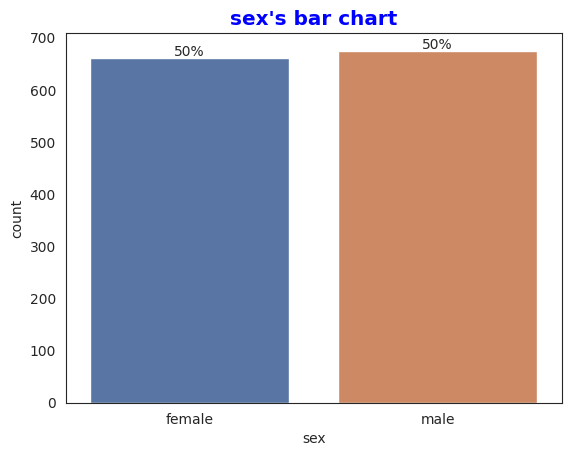

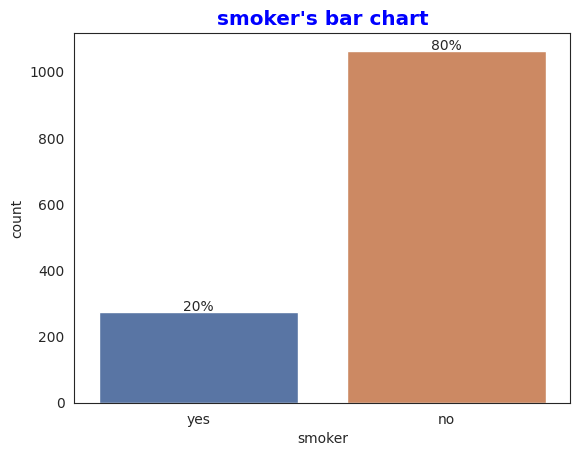

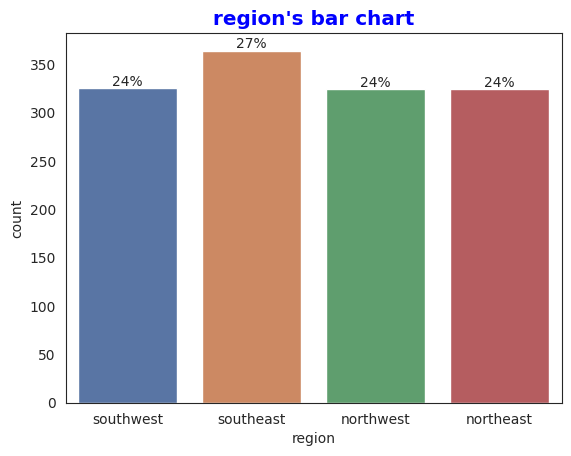

In [24]:
total = len(cleaned_df)

for col in cleaned_df.select_dtypes(include="object").columns:
    bar_chart(cleaned_df, col, out=True)

> **ANALYSIS**
>
> `sex` and `region` are rather well-balanced, while `smoker` is unbalanced, with a 80%-20% distribution of non-smokers/smokers.
>
> **In terms of machine learning, this will lead us to stratify the dataset according to this variable when performing the hold-out**.

# Bivariate Analysis

## Correlations Including Numerical Features And Binary Ones

### Correlation Heatmap

**☝️ For binary features, it is adapted to use `pearsonr` (but they need to be encoded beforehand).**

What this means, is that **we can extend the correlation heatmap**, not omitting to encode binary variables just before it.

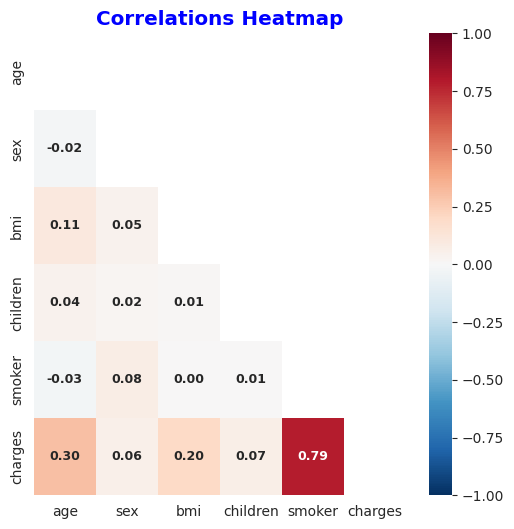

In [25]:
sex_mapping = {"female": 0, "male": 1}
smoker_mapping = {"no": 0, "yes": 1}

bin_cleaned_df = cleaned_df.assign(
    sex = cleaned_df.sex.map(sex_mapping),
    smoker = cleaned_df.smoker.map(smoker_mapping)
)

correlation_heatmap(bin_cleaned_df)

> **ANALYSIS**
>
> As emphasized during overview, **`smoker` is strongly correlated with the target, and moderately correlated with `age`, then `bmi`**.
>
> Between features, there aren't really relevant correlations, except a slight one between `age` and `bmi`. (this one will be explored afterwards)

### Graphs Corroborating This

#### `smoker` and `charges`

All these will add illustration to the initial scatterplot underlined within the pairplot.

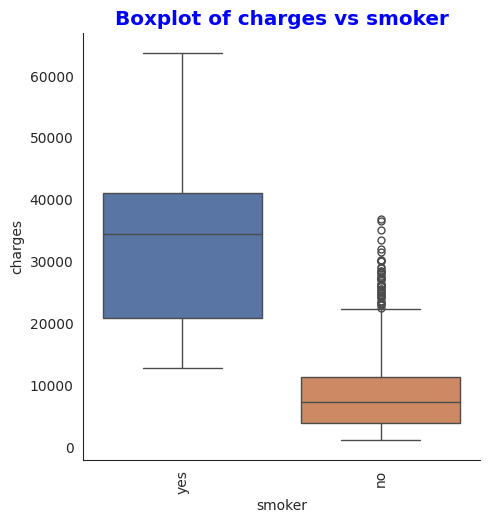

In [26]:
catplot("smoker")

> The difference in charges appear clearly

#### `age` and `charges`

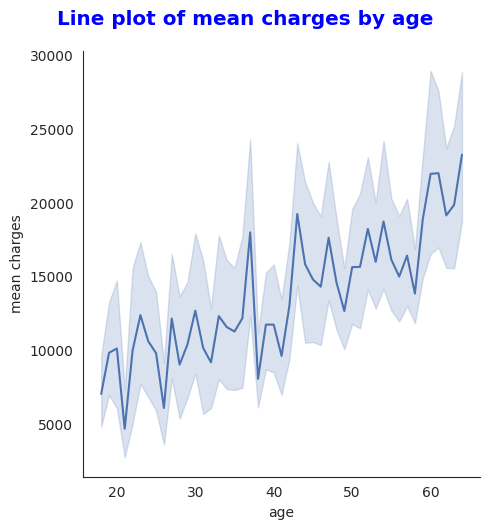

In [27]:
lineplot("age", out=True)

> Despite large variability, an ascending trend is clearly appearing

#### `charges` and `bmi`

☝️ **To better illustrate the differences, we will tranform `bmi` into a nominal variable, first with 4 categories, then 6, splitting `Obesity` further.**

In [28]:
cleaned_df["bmi_4_cats"] = cleaned_df.bmi.apply(split_bmi_in_four)

In [29]:
cleaned_df.bmi_4_cats.value_counts()

bmi_4_cats
Obesity          706
Overweight       386
Normal Weight    225
Underweight       20
Name: count, dtype: int64

☝️ **Note that the `Underweight` category is clearly under-represented**

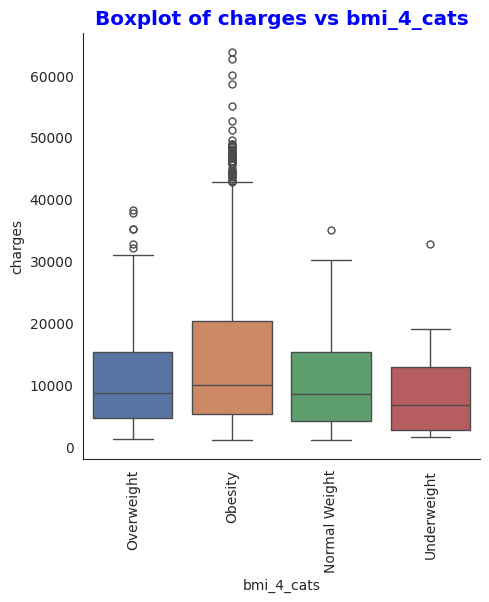

In [44]:
catplot("bmi_4_cats")

In [31]:
cleaned_df["bmi_6_cats"] = cleaned_df.bmi.apply(split_bmi_in_six)

In [32]:
cleaned_df.bmi_6_cats.value_counts()

bmi_6_cats
Class I Obesity      390
Overweight           386
Normal Weight        225
Class II Obesity     225
Class III Obesity     91
Underweight           20
Name: count, dtype: int64

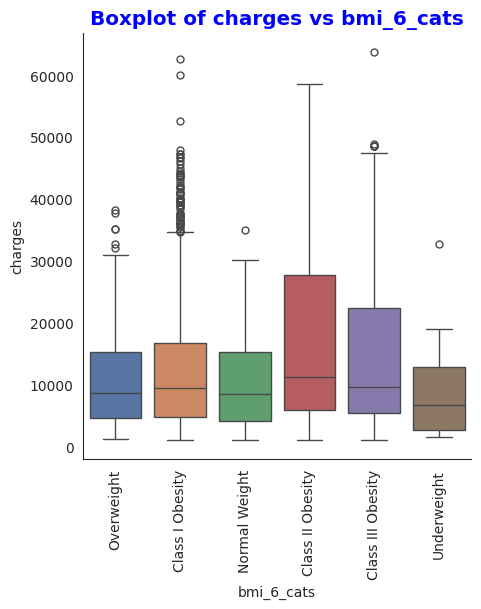

In [45]:
catplot("bmi_6_cats")

> All these corroborate the correlation matrix.

## Correlations Between Numerical and Nominal

### `region` and `charges`

#### kdeplot

Let's study the correlation between `region` and `charges`

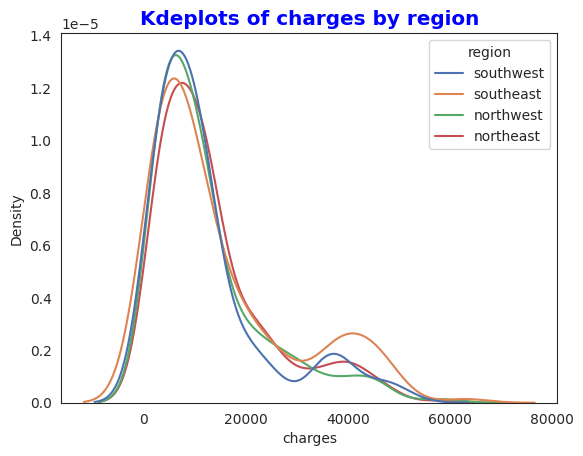

In [55]:
kdeplots("region")

> As mentioned during the pairplot, **the distribution for SouthEast seems to be slightly different**.
>
> Remember also that these classes are rather well balanced

#### Boxplot

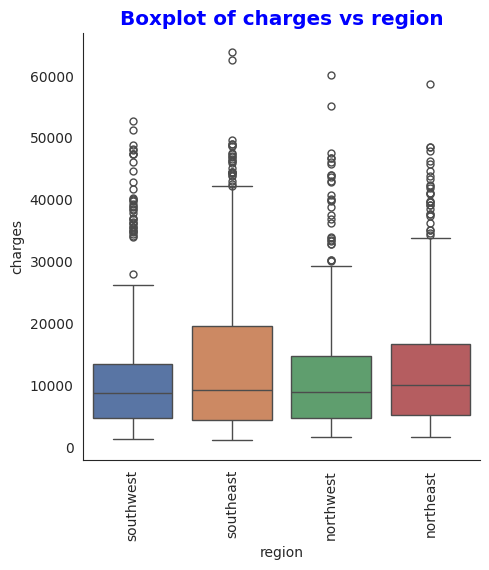

In [46]:
catplot("region")

> The difference doesn't appear very clear, except for SouthEast's IQR which is larger than other ones.

#### ANOVA

Let's perform a one-way ANOVA to prove that there is a difference.

- Our Null Hypothesis $H_0$ will be that there's no difference in mean nor variance
- Out Alternate Hypothesis $H_1$ will be that there is a difference.

In [41]:
# Chosen threshold
alpha = 0.05

In [38]:
f_stat, p = one_way_anova("region")
f_stat, p

(2.926139903662777, 0.03276288025444947)

In [39]:
k = cleaned_df.region.nunique()  # Number of groups
N = len(cleaned_df)  # Total sample size
k, N

(4, 1337)

In [42]:
df_between = k - 1
df_within = N - k

critical_value = f.ppf(1 - alpha, df_between, df_within)
print(f"{critical_value = }")

critical_value = 2.611578225607223


> **ANALYSIS**
>
> `p` is under the statistical threshold and `f_stat` is over the critical value, hence we can conclude that there's at least one region that has charges which are statistically different than others.

☝️ **We could now lead post-hoc tests to find out what are the regions that differ from each other, but we won't do it here, rather study if we find these coefficients in our post-fit analysis of feature importance.**

### `children` and `charges`

☝️ In this section, we consider `children` as a nominal variable, in order to lead a similar analysis as previously.

In [60]:
cleaned_df.children.value_counts()

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

> It's worth noting that **groups are here very unbalanced**.

#### Boxplot

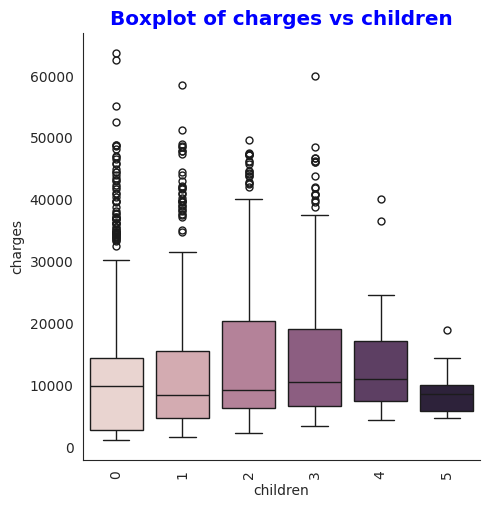

In [43]:
catplot("children")

> It doesn't appear obviously that there is a difference, **except for the last distibution, which indeed seems different from the others**.

#### kdeplots

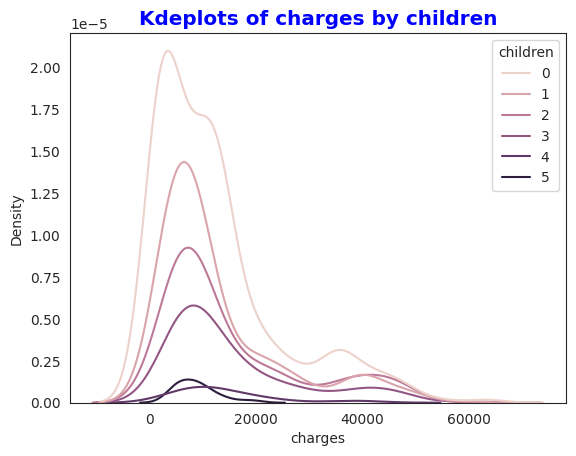

In [56]:
kdeplots("children")

#### ANOVA

In [57]:
f_stat, p = one_way_anova("children")
f_stat, p

(3.2687344101195737, 0.006133448188169501)

In [58]:
k = cleaned_df.children.nunique()  # Number of groups
N = len(cleaned_df)  # Total sample size
k, N

(6, 1337)

In [59]:
df_between = k - 1
df_within = N - k

critical_value = f.ppf(1 - alpha, df_between, df_within)
print(f"{critical_value = }")

critical_value = 2.2208225399708423


> **ANALYSIS**
>
> `p` is far under the statistical threshold and `f_stat` is over the critical value, hence we can conclude that there's at least one childrean category that has charges which are statistically different than others.

## Correlations Between Nominal Features

Let's try to see if `smoker` and `region` are correlated.

In [69]:
smoker_region_ct = contingency_table("smoker", "region")
smoker_region_ct

region,northeast,northwest,southeast,southwest
smoker,,,,
no,257,266,273,267
yes,67,58,91,58


In [71]:
chi2, p, dof, expected = chi2_contingency(smoker_region_ct)
p

0.06354826573182332

> The p-value being greater than our chosen threshold, **we fail to reject the null hypothesis, and conclude these variables are not correlated**.